In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : Catboost   ######################## 
########################       Polarity on Reviews      ########################
########################       Negative vs Positive     ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Apr 20 01:05:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [5]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [7]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,"[order, chicken, finger, sub, honey, mustard, ...",Negative,3.0
3,"[dedicated, loving, memory, gary, feldman, gre...",Negative,5.0
12,"[absolutely, horrible, thought, would, order, ...",Negative,1.0
15,"[found, better, chicken, finger, know, inside,...",Negative,4.0
20,"[amazing, everything, tried, disappoint, chick...",Negative,5.0


In [8]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [9]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,cleanReview,sentiment,stars_reviews
index,,,
1,"[""order"", ""chicken"", ""finger"", ""sub"", ""honey"",...",Negative,3.0
3,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel...",Negative,5.0
12,"[""absolutely"", ""horrible"", ""thought"", ""would"",...",Negative,1.0
15,"[""found"", ""better"", ""chicken"", ""finger"", ""know...",Negative,4.0
20,"[""amazing"", ""everything"", ""tried"", ""disappoint...",Negative,5.0


In [10]:
# Recode to binary
df = df.copy()
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [23]:
df = df.copy()
df['sentiment'] = df['sentiment'].astype('int')
df.dtypes

cleanReview       object
sentiment          int64
stars_reviews    float64
dtype: object

In [24]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [12]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [13]:
# Load model
word2vec_path = 'gensim_w2vModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [14]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [15]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f10e4348590>)])

In [25]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL


In [26]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [27]:
################################################################################
######################     Catboost Optuna HPO  ################################
######################         100 trials       ################################
################################################################################
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_sentPol.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [28]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_sentPol.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
284:	learn: 0.0969939	test: 0.1178149	best: 0.1178149 (284)	total: 7.96s	remaining: 2.37s
285:	learn: 0.0969114	test: 0.1177982	best: 0.1177982 (285)	total: 7.99s	remaining: 2.35s
286:	learn: 0.0968452	test: 0.1177929	best: 0.1177929 (286)	total: 8.02s	remaining: 2.32s
287:	learn: 0.0968012	test: 0.1177828	best: 0.1177828 (287)	total: 8.04s	remaining: 2.29s
288:	learn: 0.0967418	test: 0.1177586	best: 0.1177586 (288)	total: 8.07s	remaining: 2.26s
289:	learn: 0.0966446	test: 0.1177382	best: 0.1177382 (289)	total: 8.09s	remaining: 2.23s
290:	learn: 0.0965907	test: 0.1177285	best: 0.1177285 (290)	total: 8.12s	remaining: 2.2s
291:	learn: 0.0965514	test: 0.1177180	best: 0.1177180 (291)	total: 8.15s	remaining: 2.18s
292:	learn: 0.0964763	test: 0.1176918	best: 0.1176918 (292)	total: 8.17s	remaining: 2.15s
293:	learn: 0.0964312	test: 0.1176700	best: 0.1176700 (293)	total: 8.2s	remaining: 2.12s
294:	learn: 0.0963752	test: 0.1176619	best: 0.11766

In [29]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


In [30]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_scale_pos_weight':'scale_pos_weight'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_sentPol.csv', index=False)

     iteration   logloss             datetime_start  \
59          59  0.116848 2022-04-20 02:30:47.107030   
88          88  0.117032 2022-04-20 03:09:22.592748   
82          82  0.117064 2022-04-20 03:01:08.764415   
86          86  0.117112 2022-04-20 03:06:37.055202   
93          93  0.117115 2022-04-20 03:16:07.881996   
..         ...       ...                        ...   
8            8  0.690358 2022-04-20 01:22:27.765778   
100        100  0.692226 2022-04-20 03:25:37.056611   
27          27  0.692242 2022-04-20 01:46:36.953796   
6            6  0.692465 2022-04-20 01:19:58.239959   
0            0       NaN 2022-04-20 01:05:44.981257   

             datetime_complete               duration  depth  n_estimators  \
59  2022-04-20 02:32:07.928794 0 days 00:01:20.821764    9.0         410.0   
88  2022-04-20 03:10:44.875850 0 days 00:01:22.283102   10.0         360.0   
82  2022-04-20 03:02:32.595854 0 days 00:01:23.831439   10.0         410.0   
86  2022-04-20 03:07:59.706

In [31]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations


In [32]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [33]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [34]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [35]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [36]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


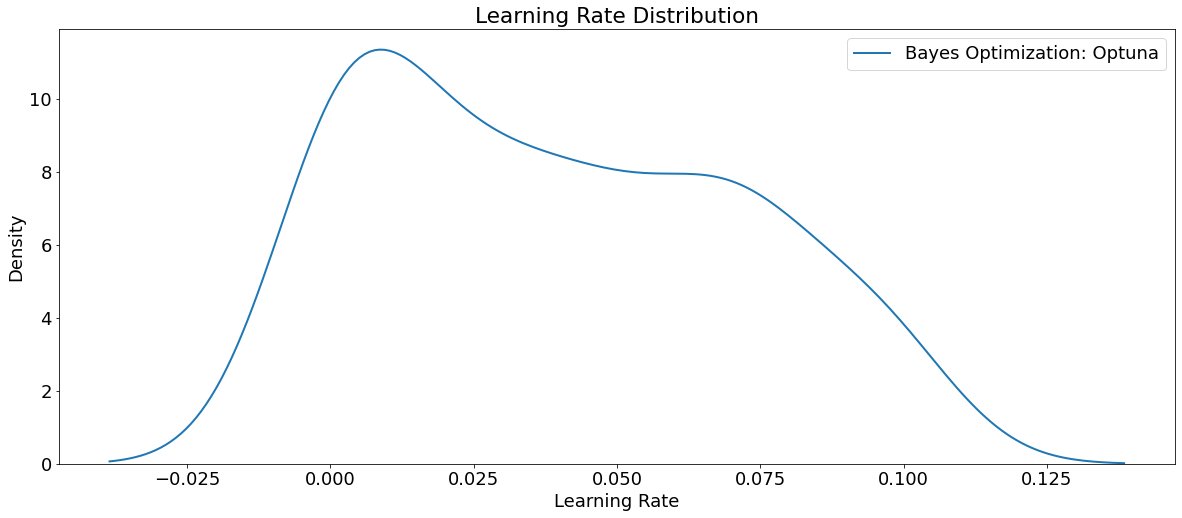

In [37]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

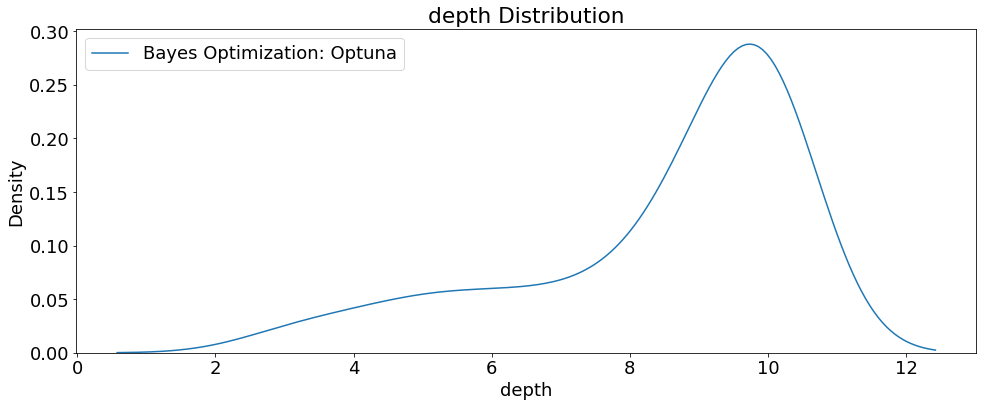

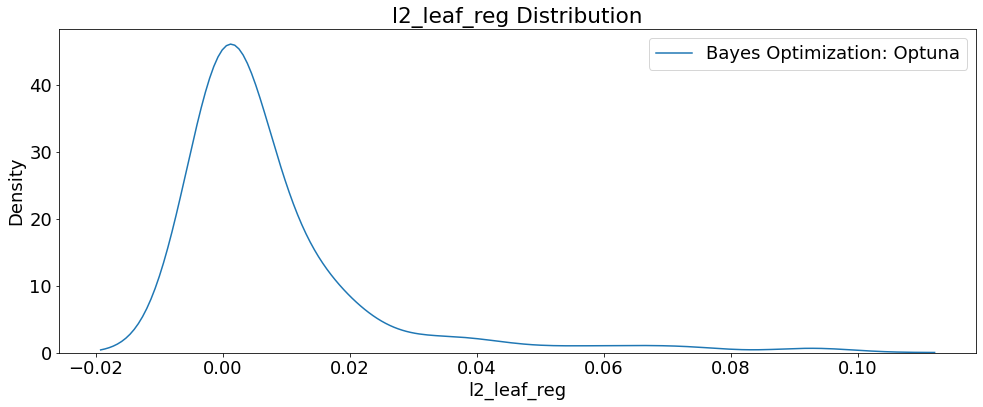

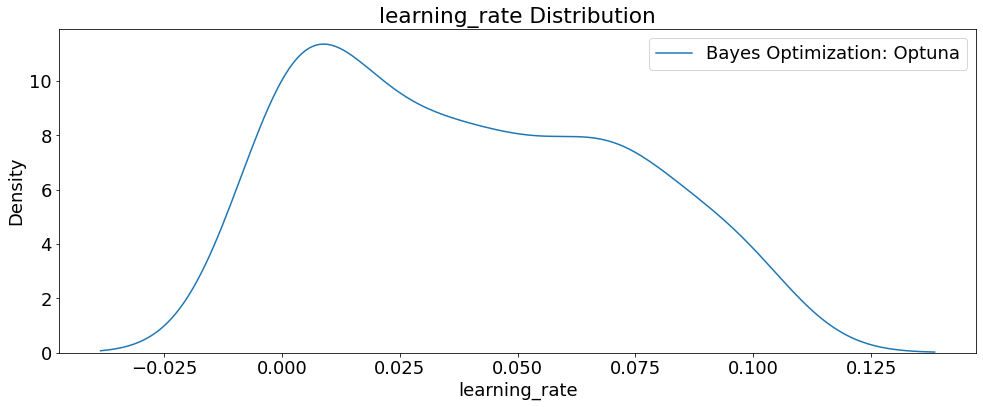

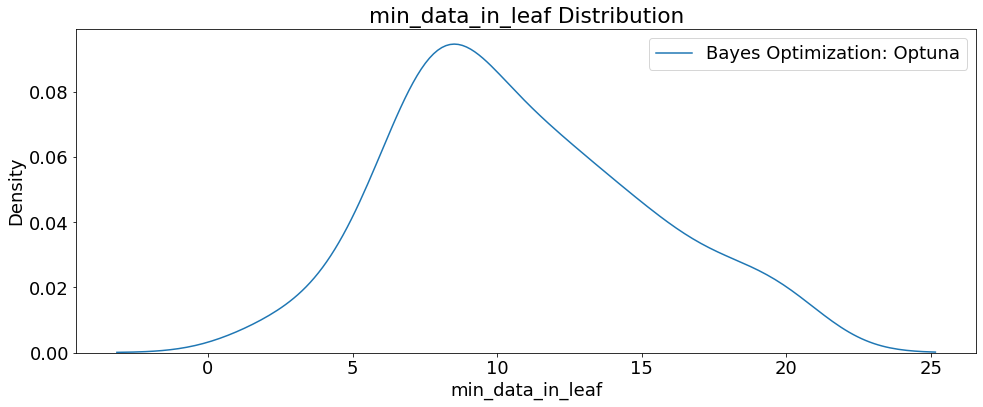

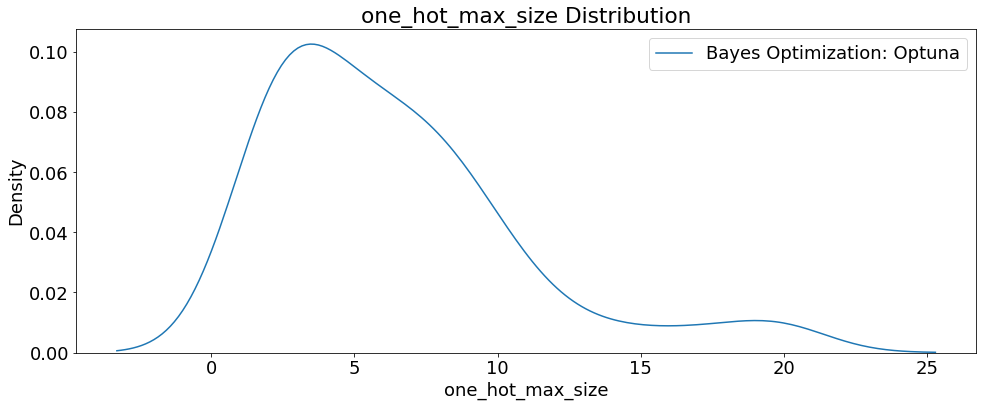

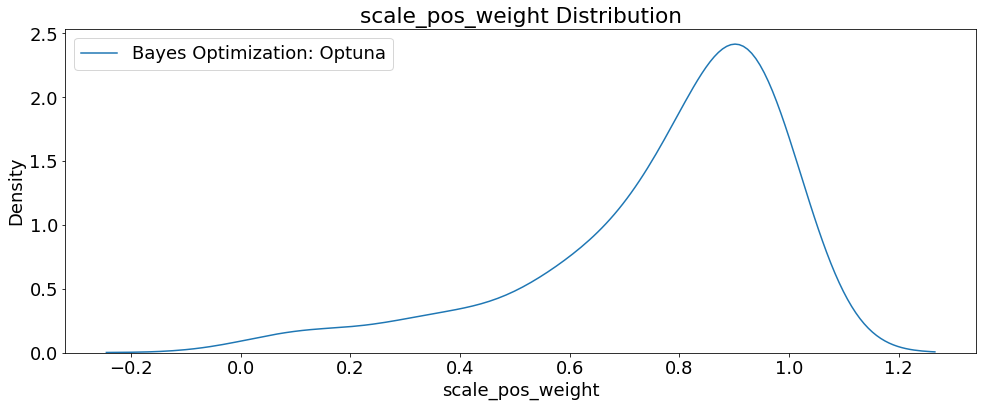

In [38]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



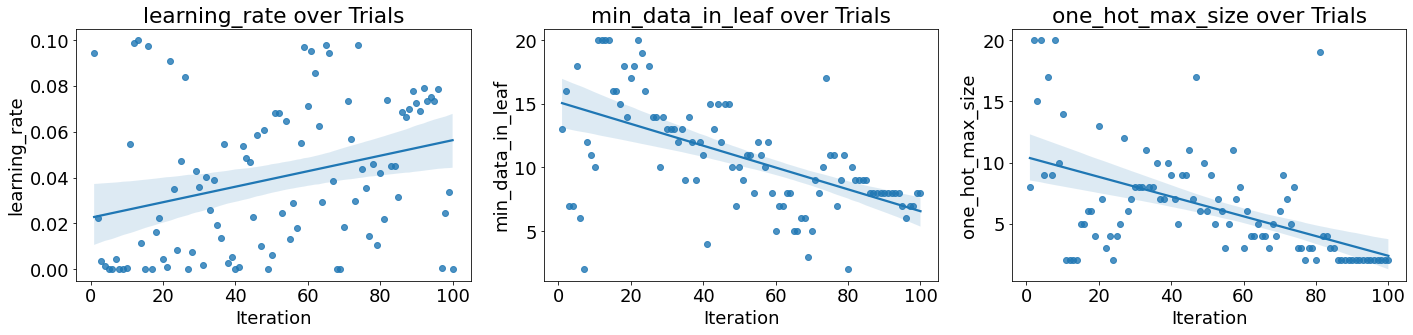

In [39]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



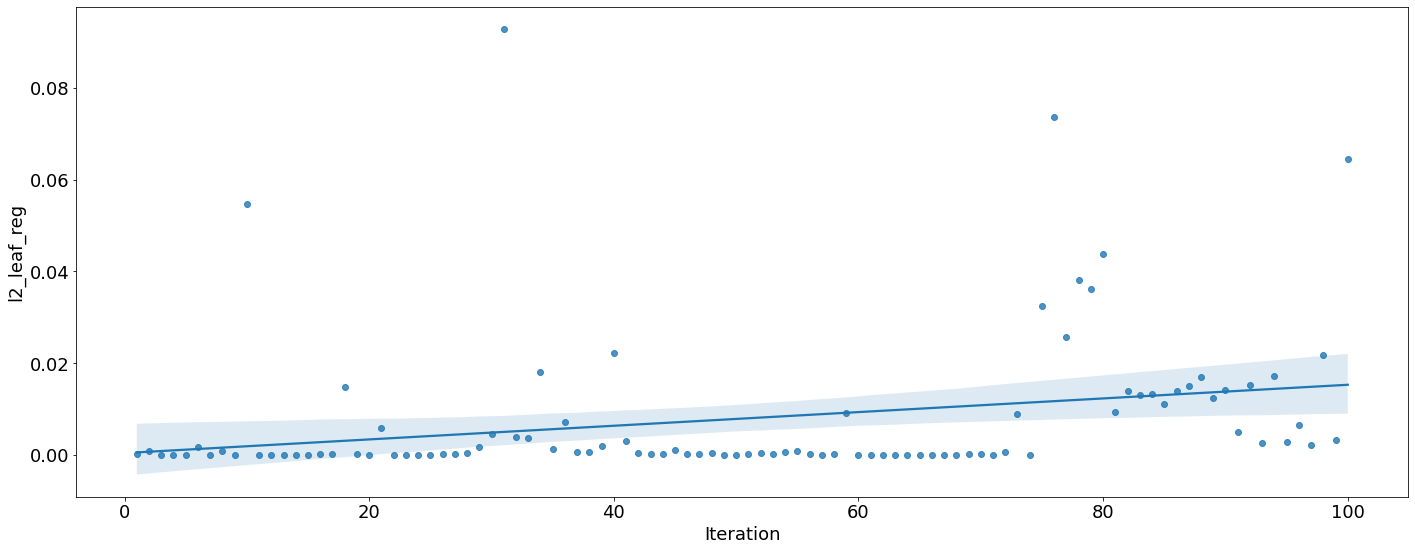

In [40]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = trials_df, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [41]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_Explanations


In [42]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [43]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_sentPol.html')
fig.show()

In [44]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 9,
 'iterations': 410,
 'l2_leaf_reg': 0.009100566104195795,
 'learning_rate': 0.09716267842854127,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 8,
 'one_hot_max_size': 8,
 'random_state': 42,
 'scale_pos_weight': 0.9926878059625376}

In [45]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL/


study = joblib.load('Catboost_Optuna_100_GPU_sentPol.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/Model_PKL


In [50]:
label = df[['sentiment']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [51]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [53]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(early_stopping_rounds=100,
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                                **params)
# Fit the model
#.ravel()
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_sentPol.pkl')
# print(model)
# =============================================================================

In [54]:
print('Results from Catboost HPO Optuna 100 GPU Sentiment Polarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU Sentiment Polarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    331950
           1       0.97      0.97      0.97    331949

    accuracy                           0.97    663899
   macro avg       0.97      0.97      0.97    663899
weighted avg       0.97      0.97      0.97    663899



Confusion matrix: Train
[[321303  10647]
 [ 11574 320375]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82987
           1       0.96      0.96      0.96     82988

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79528  3459]
 [ 3695 79293]]


Accuracy score: train: 0.967, test: 0.957
Precision score: train: 0.968, test: 0.958
Recall score:

In [55]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/SentimentPolarity/trialOptions


In [56]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95690 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    59
logloss                                0.116848
datetime_start       2022-04-20 02:30:47.107030
datetime_complete    2022-04-20 02:32:07.928794
duration                 0 days 00:01:20.821764
depth                                       9.0
n_estimators                              410.0
l2_leaf_reg                            0.009101
learning_rate                          0.097163
min_data_in_leaf                            8.0
one_hot_max_size                            8.0
scale_pos_weight                       0.992688
state                                  COMPLETE
Name: 0, dtype: object
